/home/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


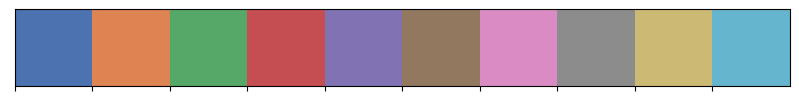

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_scatter
from tqdm import tqdm

import config_matplotlib
import seaborn as sns

cmap_global = sns.color_palette('deep')
sns.palplot(cmap_global)

In [2]:
Nb = 40
noise_level_list = [0.5, 1.0, 2.0]
pw_list = [0.1, 0.2]
datadir = 'benchmarks_2023Apr05'
task_labels = ['gd', 'baseline', 'sequential', 'random']
run_labels = [f'RUN_{i+1}' for i in range(5)]
scatter_mean_indices = torch.arange(len(task_labels)).repeat_interleave(len(run_labels))
print(scatter_mean_indices)

results = {}

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])


In [3]:
results = torch.load(os.path.join(datadir, "summarized_results.pt"))
print(results.keys())
print(results[(0.1,0.5)].keys())

dict_keys([(0.1, 0.5), (0.1, 1.0), (0.1, 2.0), (0.2, 0.5), (0.2, 1.0), (0.2, 2.0)])
dict_keys(['mean_loss_avg_over_runs_samples', 'std_loss_avg_over_runs_samples', 'loss_avg_over_runs', 'loss_full', 'loss_indices', 'param_true', 'times', 'signals', 'measured_settings', 'measured_values', 'times_finer', 'signals_finer'])


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
gamma = 0.1
pulse_width = 0.1
noise_level = 0.5
times = np.linspace(0, 3, 121)

In [6]:
def compute_gradient(value, step):
    grad = torch.zeros_like(value)
    grad[...,1:-1] = (value[...,2:] - value[...,:-2]) / (2 * step)
    grad[...,0] = (value[...,1] - value[...,0]) / step
    grad[...,-1] = (value[...,-1] - value[...,-2]) / step
    return grad

In [7]:
_result = results[(pulse_width, noise_level)]
step = (_result['times'][1] - _result['times'][0]).item()
step_finer = (_result['times_finer'][1] - _result['times_finer'][0]).item()

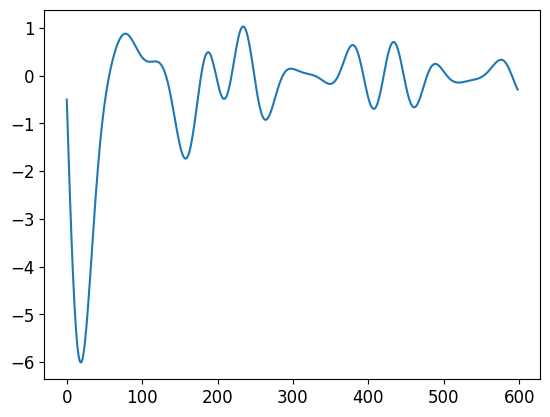

In [8]:
plt.plot(_result['signals_finer'][0,0,2:]-_result['signals_finer'][0,0,:-2])

In [9]:
grad = compute_gradient(_result['signals'], step)
grad_finer = compute_gradient(_result['signals_finer'], step_finer)
abs_grad = np.zeros((20,100))

In [10]:
measured_abs_grad_dict = {}
for key in results.keys():
    # print(key)
    _result = results[key]
    grad = compute_gradient(_result['signals'], step)
    abs_grad = np.zeros((20,100))
    for i_strat in range(20):
        for j_sample in range(100):
            indices = np.round(_result['measured_settings'][i_strat][j_sample] / step).astype('int')
            abs_grad[i_strat,j_sample] = grad[i_strat,j_sample,indices].abs().mean().item()
    measured_abs_grad = torch_scatter.scatter_mean(torch.from_numpy(abs_grad), scatter_mean_indices, dim=0)
    measured_abs_grad_dict[key] = measured_abs_grad

In [11]:
for key in results.keys():
    print(key, measured_abs_grad_dict[key].mean(dim=-1))

(0.1, 0.5) tensor([158.4739, 161.0784, 107.9719, 111.7770], dtype=torch.float64)
(0.1, 1.0) tensor([158.2094, 164.0165, 112.1075, 112.5926], dtype=torch.float64)
(0.1, 2.0) tensor([166.2978, 169.6986, 111.9416, 110.2195], dtype=torch.float64)
(0.2, 0.5) tensor([109.0204, 115.9485,  85.7939,  84.9702], dtype=torch.float64)
(0.2, 1.0) tensor([114.7787, 117.0733,  82.6440,  85.4705], dtype=torch.float64)
(0.2, 2.0) tensor([118.4299, 126.0228,  87.0368,  85.8319], dtype=torch.float64)


In [12]:
key=(0.1, 1.0)

Text(0.5, 1.0, '$w=0.1$ ps, $\\sigma=1.0$')

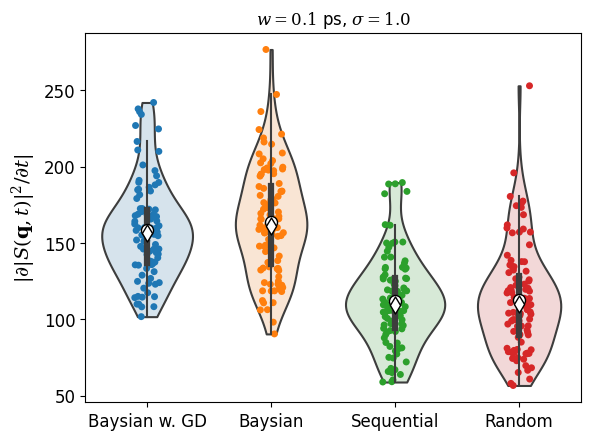

In [13]:
from matplotlib.colors import to_rgba
ylabels = ['J', 'D', '\gamma']

fig, ax = plt.subplots(1,1)
sns.violinplot([m.numpy() for m in measured_abs_grad_dict[key]], ax=ax, zorder=10, inner='box', cut=0)
for vp in ax.collections[::2]:
    vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.2))
sns.stripplot([m.numpy() for m in measured_abs_grad_dict[key]], ax=ax, zorder=1)
ax.scatter(np.arange(4), [np.median(m.numpy()) for m in measured_abs_grad_dict[key]], 
           zorder=25, edgecolors='k', facecolors='w', marker='d', s=75, label='Median')
ax.scatter(np.arange(4), [np.mean(m.numpy()) for m in measured_abs_grad_dict[key]], 
           zorder=20, edgecolors='k', facecolors='w', marker='o', s=75, label='Mean')
ax.set_xticklabels(['Baysian w. GD', 'Baysian', 'Sequential', 'Random'])
# ax.set_ylabel(rf'$|{ylabels[i_param]}-{ylabels[i_param]}^{{\ast}}|$')
ax.set_ylabel("$|\partial |S(\mathbf{q},t)|^{2}/\partial t|$")
# # ax.legend(ncols=2)
ax.set_xlim([-0.5, 3.5])
ax.set_title(f"$w={key[0]}$ ps, $\sigma={key[1]}$")

In [14]:
key=(0.1, 0.5)

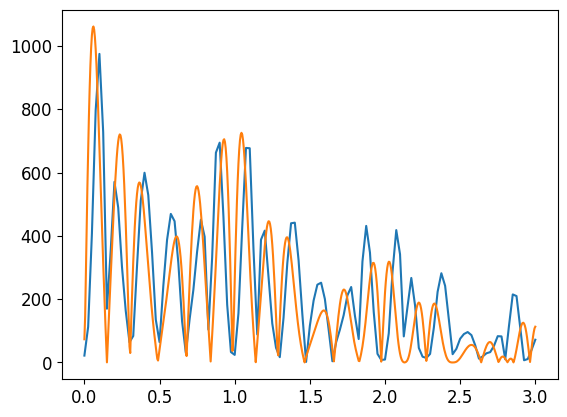

In [15]:
fig, ax = plt.subplots(1,1)
plt.plot(results[key]['times'], np.abs(grad[i_strat,j_sample]))
plt.plot(results[key]['times_finer'], np.abs(grad_finer[i_strat,j_sample]))

Text(0, 0.5, '$|\\partial s(t)\\ / \\ \\partial t|$')

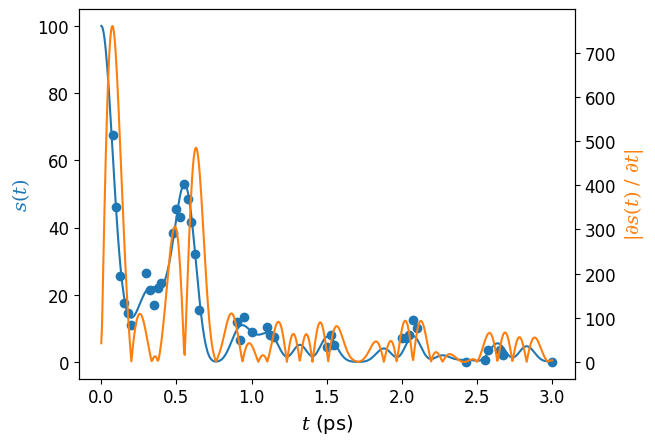

In [16]:
i_strat = 0
j_sample = 11
_result = results[key]

fig, ax = plt.subplots(1,1)
ax_twin = ax.twinx()
ax.plot(_result['times_finer'], _result['signals_finer'][i_strat,j_sample])
ax_twin.plot(_result['times_finer'], np.abs(grad_finer[i_strat,j_sample]), color='C1')
ax.scatter(_result['measured_settings'][i_strat][j_sample], _result['measured_values'][i_strat][j_sample])
ax.set_xlabel("$t$ (ps)")
ax.set_ylabel("$s(t)$", color='C0')
ax_twin.set_ylabel("$|\partial s(t)\ / \ \partial t|$", color='C1')

In [17]:
measured_abs_grad_dict_all_keys = None
for key in results.keys():
    print(key)
    if measured_abs_grad_dict_all_keys is None:
        measured_abs_grad_dict_all_keys = torch.zeros_like(measured_abs_grad_dict[key])
    else:
        measured_abs_grad_dict_all_keys += measured_abs_grad_dict[key]

measured_abs_grad_dict_all_keys = measured_abs_grad_dict_all_keys.numpy() / len(results.keys())

(0.1, 0.5)
(0.1, 1.0)
(0.1, 2.0)
(0.2, 0.5)
(0.2, 1.0)
(0.2, 2.0)


(-0.5, 3.5)

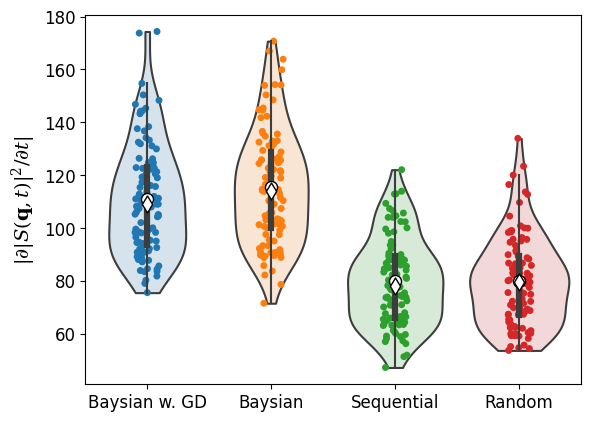

In [18]:
from matplotlib.colors import to_rgba
ylabels = ['J', 'D', '\gamma']

fig, ax = plt.subplots(1,1)
sns.violinplot([m for m in measured_abs_grad_dict_all_keys], ax=ax, zorder=10, inner='box', cut=0)
for vp in ax.collections[::2]:
    vp.set_facecolor(to_rgba(vp.get_facecolor(), alpha=0.2))
sns.stripplot([m for m in measured_abs_grad_dict_all_keys], ax=ax, zorder=1)
ax.scatter(np.arange(4), [np.median(m) for m in measured_abs_grad_dict_all_keys], 
           zorder=25, edgecolors='k', facecolors='w', marker='d', s=75, label='Median')
ax.scatter(np.arange(4), [np.mean(m) for m in measured_abs_grad_dict_all_keys], 
           zorder=20, edgecolors='k', facecolors='w', marker='o', s=75, label='Mean')
ax.set_xticklabels(['Baysian w. GD', 'Baysian', 'Sequential', 'Random'])
# ax.set_ylabel(rf'$|{ylabels[i_param]}-{ylabels[i_param]}^{{\ast}}|$')
ax.set_ylabel("$|\partial |S(\mathbf{q},t)|^{2}/\partial t|$")
# # ax.legend(ncols=2)
ax.set_xlim([-0.5, 3.5])
# ax.set_title(f"$w={key[0]}$ ps, $\sigma={key[1]}$")

In [19]:
from sklearn.neighbors import KernelDensity

In [20]:
with open("benchmarks_2023Mar28/RUN_1/bayesian_gd_pw-0.1_nl-0.5_Nb-40.pkl", 'rb') as f:
    data_dict = pickle.load(f)

In [21]:
i_sample = 25

In [22]:
error_before = []
error_after = []
for i_sample in range(100):
    error_before.append(np.linalg.norm(data_dict[i_sample]['param_mean'][12,:2] - data_dict[i_sample]['param_true'][:2]))
    error_after.append(np.linalg.norm(data_dict[i_sample]['param_mean'][16,:2] - data_dict[i_sample]['param_true'][:2]))

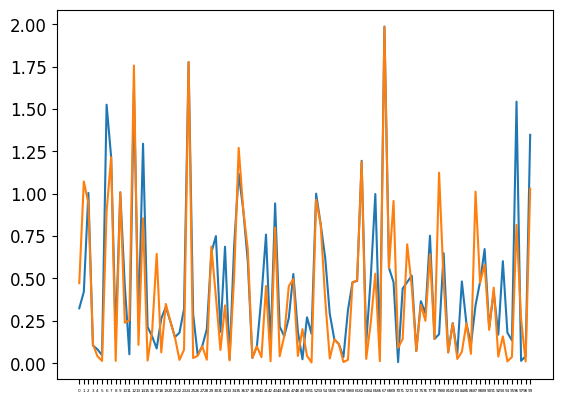

In [23]:
fig, ax = plt.subplots(1,1)
ax.plot(error_before)
ax.plot(error_after)
ax.set_xticks(np.arange(100));
ax.set_xticklabels(np.arange(100), fontsize=3);
fig.savefig('loss.pdf')

In [24]:
i_sample = 93

n_iter = 12
X_before = data_dict[i_sample]['particles'][n_iter,:2]
X_weight_before = data_dict[i_sample]['particle_weights'][n_iter]
X_true = data_dict[i_sample]['param_true']
kde_before = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_before.T, X_weight_before)
# log_dens = kde.score_samples(X_plot)

J_grid, D_grid = np.meshgrid(np.linspace(-3,-1,201),np.linspace(-1,0,101))
X_grid = np.concatenate([J_grid[...,None], D_grid[...,None]], axis=-1).reshape(-1,2)
log_dens_before = kde_before.score_samples(X_grid).reshape(J_grid.shape)

n_iter = 16
X_after = data_dict[i_sample]['particles'][n_iter,:2]
X_weight_after = data_dict[i_sample]['particle_weights'][n_iter]
kde_after = KernelDensity(kernel="exponential", bandwidth="scott").fit(X_after.T, X_weight_after)
# log_dens = kde.score_samples(X_plot)

log_dens_after = kde_after.score_samples(X_grid).reshape(J_grid.shape)


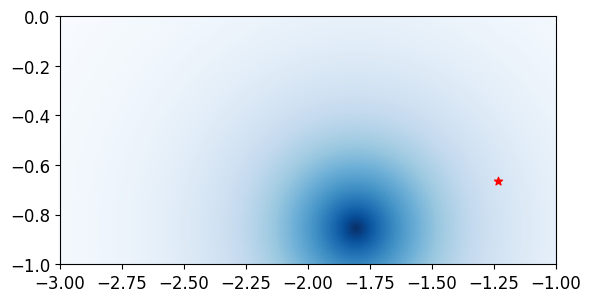

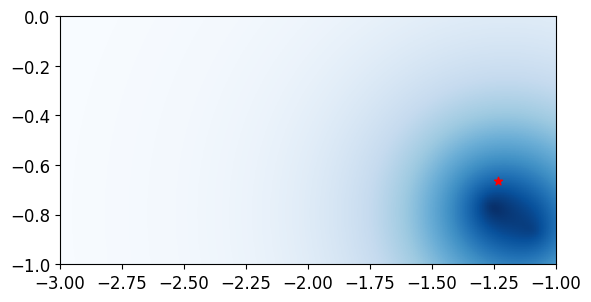

In [25]:

fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_dens_before), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
# ax.scatter(X[0], X[1])
ax.scatter(X_true[0], X_true[1], marker='*', color='r')
ax.set_aspect('equal')

fig, ax = plt.subplots(1,1)
ax.imshow(np.exp(log_dens_before), extent=[-3, -1, -1, 0], origin='lower', cmap='Greens')
ax.imshow(np.exp(log_dens_after), extent=[-3, -1, -1, 0], origin='lower', cmap='Blues')
# ax.scatter(X[0], X[1])
ax.scatter(X_true[0], X_true[1], marker='*', color='r')
ax.set_aspect('equal')